In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

import warnings 
warnings.filterwarnings("ignore")


# LSTM RNN for Time Series with Support Function

## 0. Introduction and Motivation

The problem of time series forecasting is a recurrent topic in today's world, with applications spanning across various industries. In this work, an alternative method is presented by combining LSTM RNN and Support Function.  
The objective of this notebook is to provide an open moethod that can be appliad to a production ready code, therefore its structure favours flow of logic rather than code optimization for production.

## 1. Objective

The objective of this work is to provide a method for time series forecasting based on LSTM RNN with Support Function.

## 2. Setting

This method will be applicable to any setting similar to the one described below:

- A time series with trend, seasonality, and at least 2 full period iterations;
- The objective is to forecast the future behavior of the time series;
- There is a possibility to extract a support function.

## 3. Method

The method consists of the following steps:

1. Levels Determination;
2. Support Function Extraction;
3. LSTM.


In [2]:
# simple functions to read and visualize the data

def read_data(file):
	df = pd.read_csv(file)
	df = df[['date','target']]
	df['date'] = pd.to_datetime(df['date'])
	return df

def split_data(df,future):
     df_1 = df[df['date']<future]
     df_2 = df[df['date']>=future]
     return df

def plot_yearly_data(df,variable):
    unique_years = df['date'].dt.year.unique().tolist()
    
    for year in unique_years:
        plt.figure(figsize=(15, 5))

        year_data = df[df['date'].dt.year == year]

        plt.plot(year_data['date'], year_data[variable], label=f'Target for {year}')

        plt.title(f'Target Variation for Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [4]:
df = read_data('ts_test.csv')
df

date      target
0    2020-01-01  210.822618
1    2020-01-02  207.980330
2    2020-01-03  216.320550
3    2020-01-04  226.761512
4    2020-01-05  243.301276
...         ...         ...
1456 2023-12-27  307.799558
1457 2023-12-28  295.534048
1458 2023-12-29  308.384317
1459 2023-12-30  324.791300
1460 2023-12-31  332.755803

[1461 rows x 2 columns]

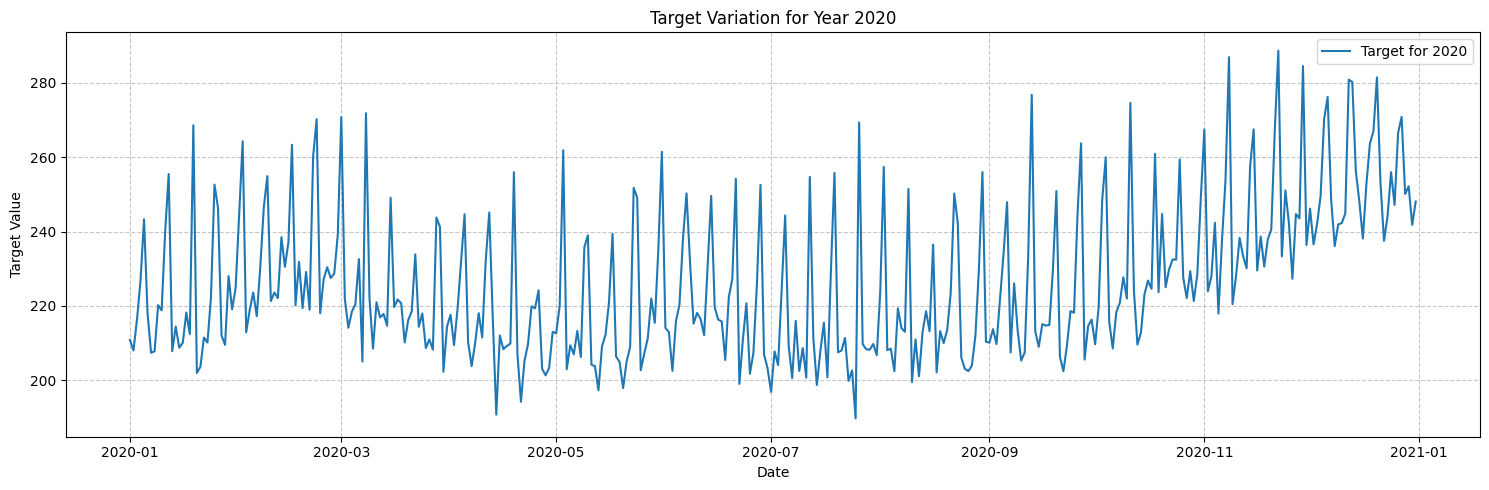

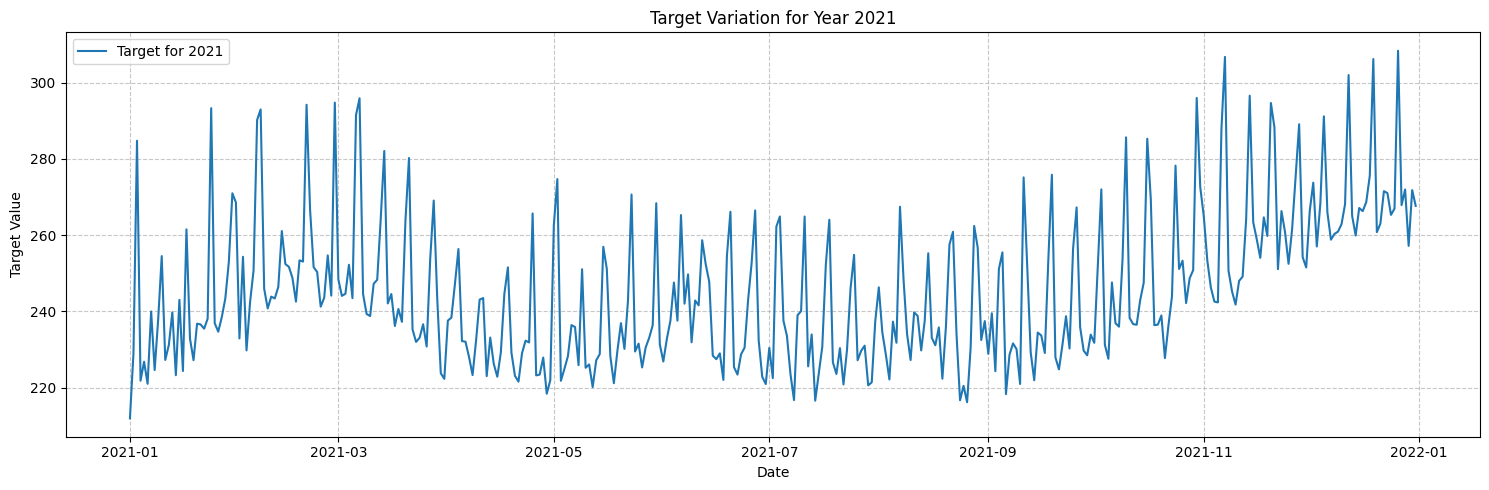

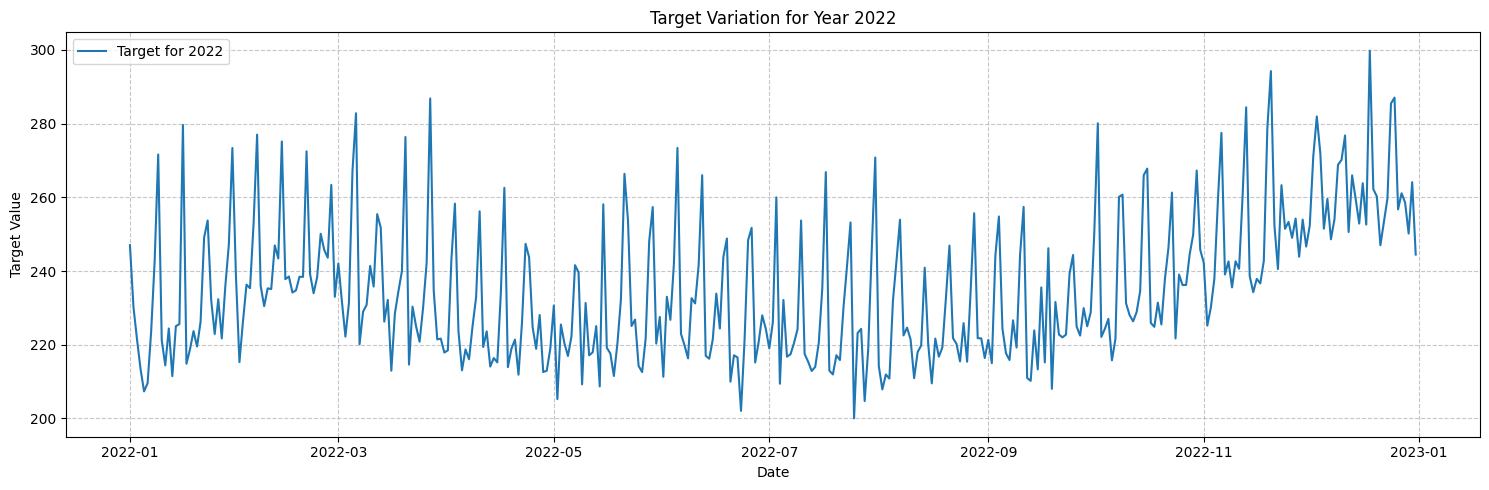

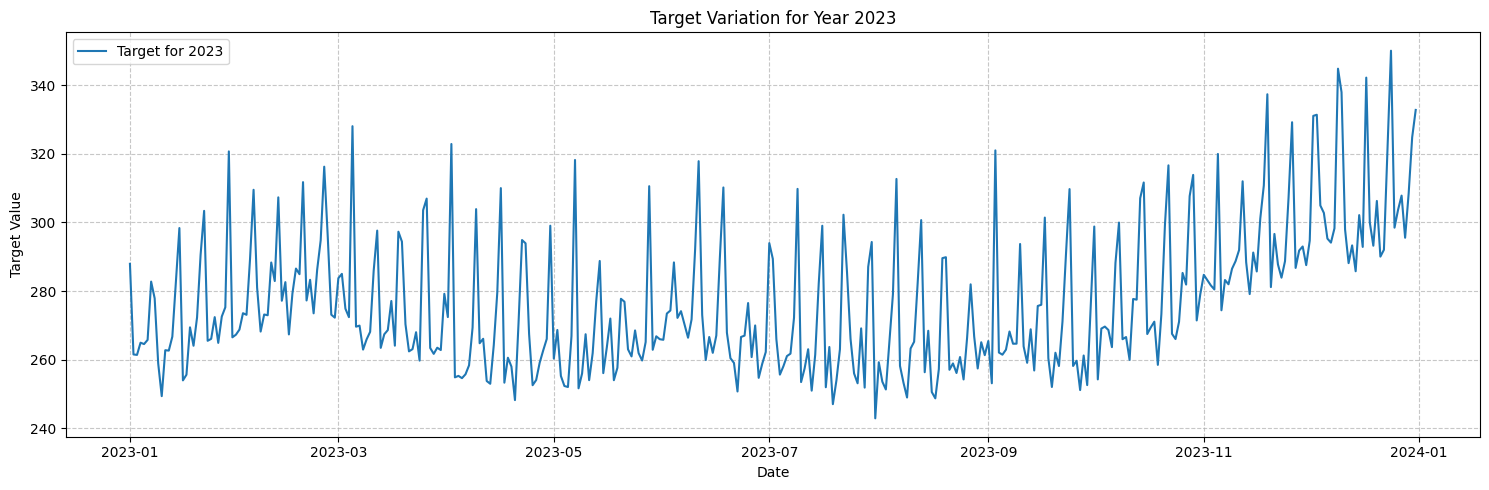

In [5]:
plot_yearly_data(df,'target')

We can observe that there exists seasonality and levels in the data with some noise.  
It is important to level the data in order to approach stationarity.  
This levelling can be done in several ways, in this case we will use simple mean value.

In [6]:
# function to level the yearly data
def level_data(df, target_year):
    unique_years = df.loc[df['date'].dt.year != target_year, 'date'].dt.year.unique().tolist()
    target_year_mean = df[df['date'].dt.year == target_year]['target'].mean()
    df['target_levelled'] = np.nan
    
    for year in unique_years:
        mean = df[df['date'].dt.year == year]['target'].mean()
        year_diff = mean - target_year_mean
        df.loc[df['date'].dt.year == year, 'target_levelled'] = df.loc[df['date'].dt.year == year, 'target'] - year_diff
    
    # Copy the target values for the target year
    df.loc[df['date'].dt.year == target_year, 'target_levelled'] = df.loc[df['date'].dt.year == target_year, 'target']
    
    return df

df = level_data(df,2023)

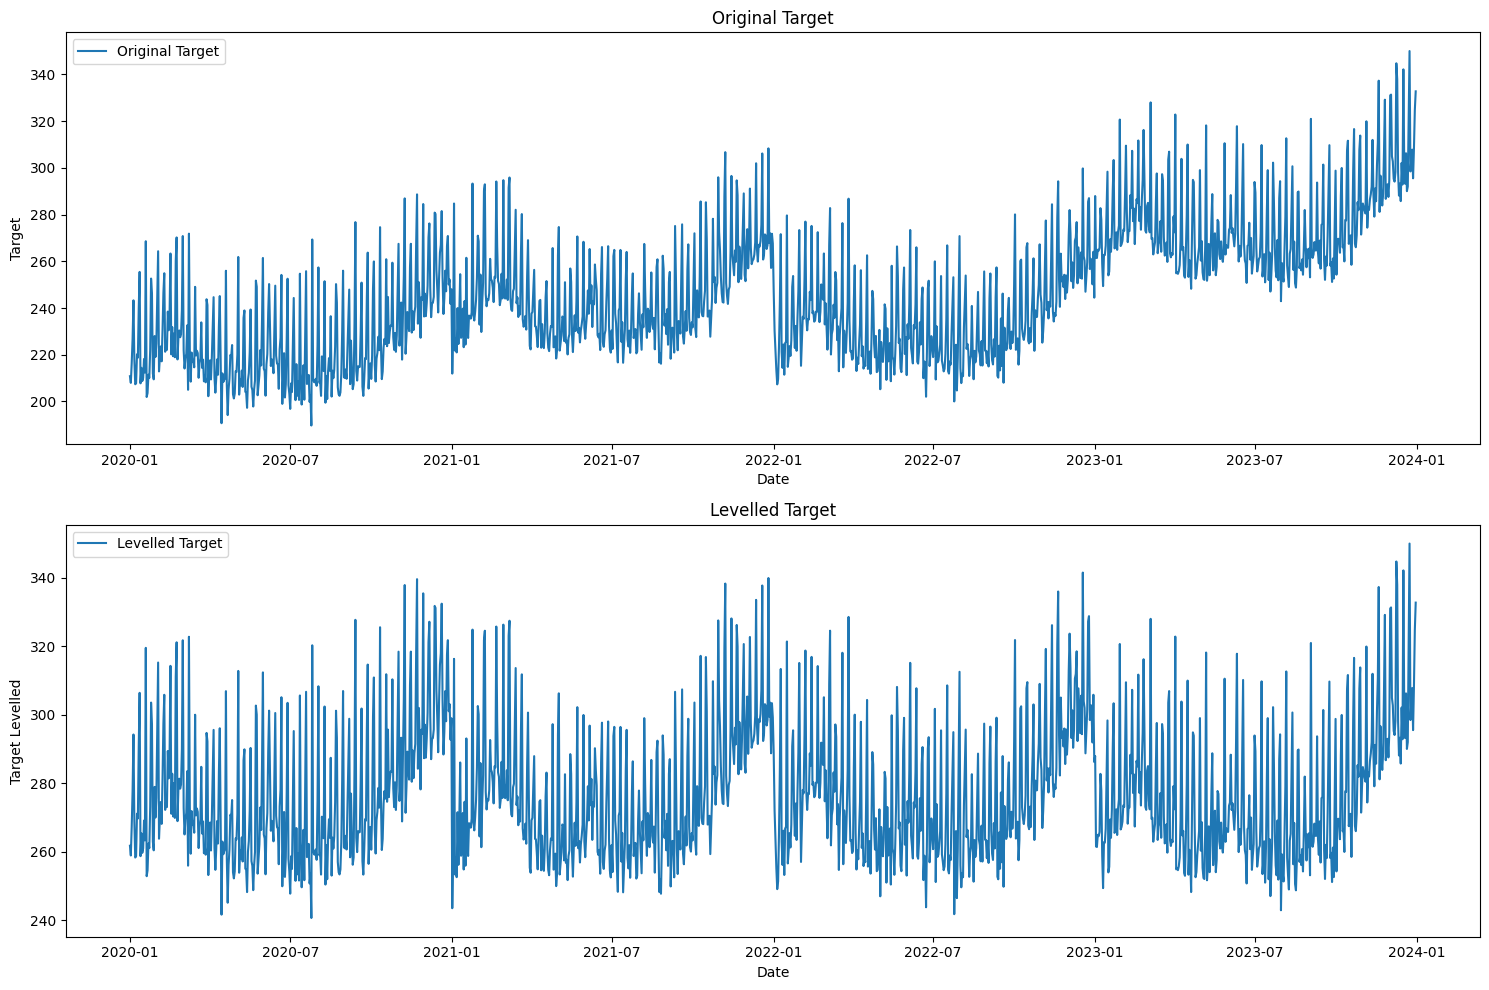

In [7]:
# Assuming df is your DataFrame
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['target'], label='Original Target')
plt.title('Original Target')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['target_levelled'], label='Levelled Target')
plt.title('Levelled Target')
plt.xlabel('Date')
plt.ylabel('Target Levelled')
plt.legend()

plt.tight_layout()

plt.show()

The data is now levelled.  
LSTM requires the data to be standardized due to the weights attribution. We will use Logarithm and Standard Scaler.

In [9]:
df

date      target  target_levelled
0    2020-01-01  210.822618       261.770549
1    2020-01-02  207.980330       258.928261
2    2020-01-03  216.320550       267.268481
3    2020-01-04  226.761512       277.709443
4    2020-01-05  243.301276       294.249207
...         ...         ...              ...
1456 2023-12-27  307.799558       307.799558
1457 2023-12-28  295.534048       295.534048
1458 2023-12-29  308.384317       308.384317
1459 2023-12-30  324.791300       324.791300
1460 2023-12-31  332.755803       332.755803

[1461 rows x 3 columns]

In [10]:
def scale_data(df, variable):
    scaler = StandardScaler()
    df[variable] = np.log(df[variable])
    df_2 = df.copy()
    
    y = df_2[variable].values.reshape(-1, 1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    df_2[variable + '_transf'] = y.flatten()
    #df_2[variable + '_transf'] = np.log(df_2[variable + '_transf'])
    return [df_2, scaler]

scaling_results = scale_data(df,'target_levelled')
df_scalled = scaling_results[0]
scaler = scaling_results[1]

In [11]:
df_scalled

date      target  target_levelled  target_levelled_transf
0    2020-01-01  210.822618         5.567468               -0.777471
1    2020-01-02  207.980330         5.556551               -0.933842
2    2020-01-03  216.320550         5.588254               -0.479759
3    2020-01-04  226.761512         5.626575                0.069131
4    2020-01-05  243.301276         5.684427                0.897752
...         ...         ...              ...                     ...
1456 2023-12-27  307.799558         5.729449                1.542607
1457 2023-12-28  295.534048         5.688784                0.960158
1458 2023-12-29  308.384317         5.731347                1.569793
1459 2023-12-30  324.791300         5.783183                2.312251
1460 2023-12-31  332.755803         5.807409                2.659246

[1461 rows x 4 columns]

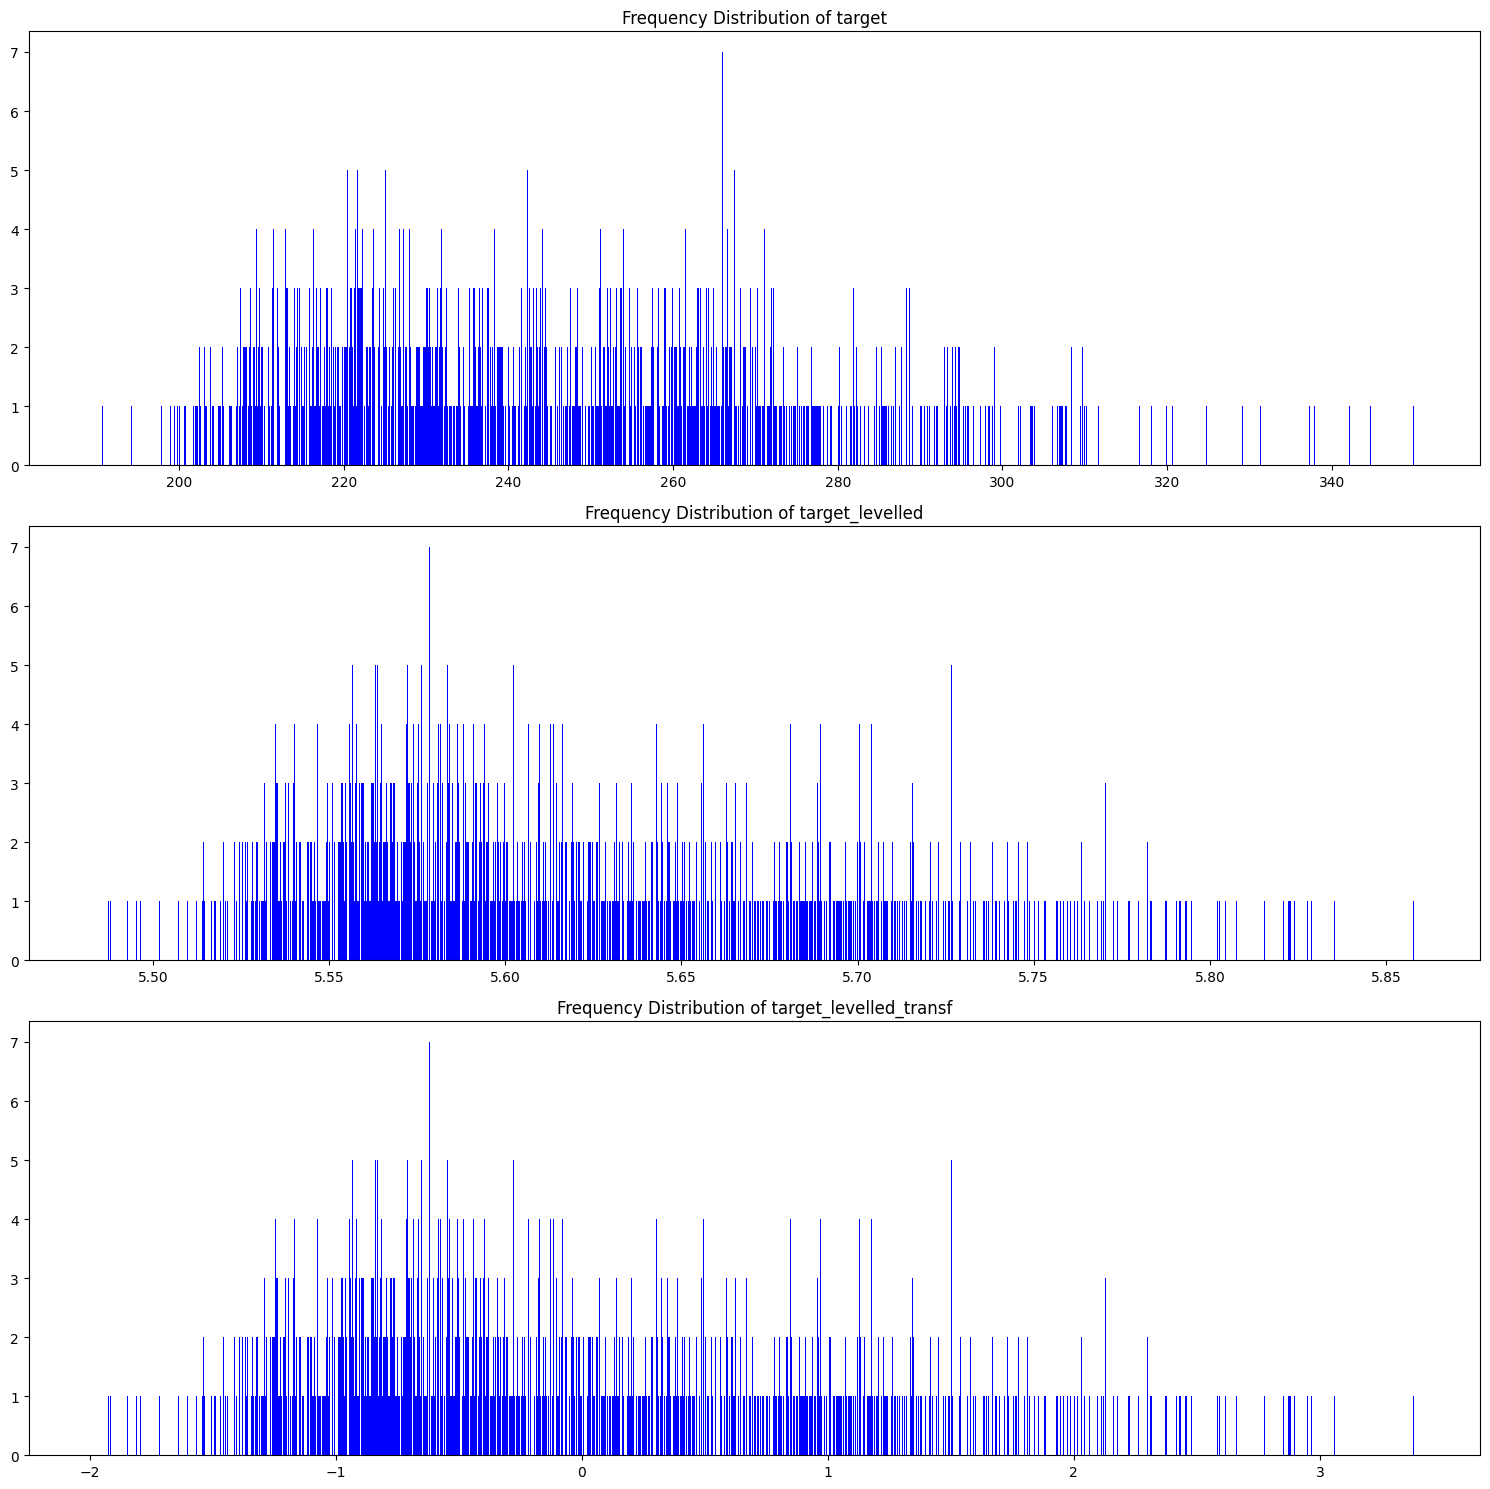

In [12]:


# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Plot the first histogram
axs[0].hist(df_scalled['target'], bins=2000, color='blue')
axs[0].set_title('Frequency Distribution of target')

# Plot the second histogram
axs[1].hist(df_scalled['target_levelled'], bins=2000, color='blue')
axs[1].set_title('Frequency Distribution of target_levelled')

# Plot the third histogram
axs[2].hist(df_scalled['target_levelled_transf'], bins=2000, color='blue')
axs[2].set_title('Frequency Distribution of target_levelled_transf')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


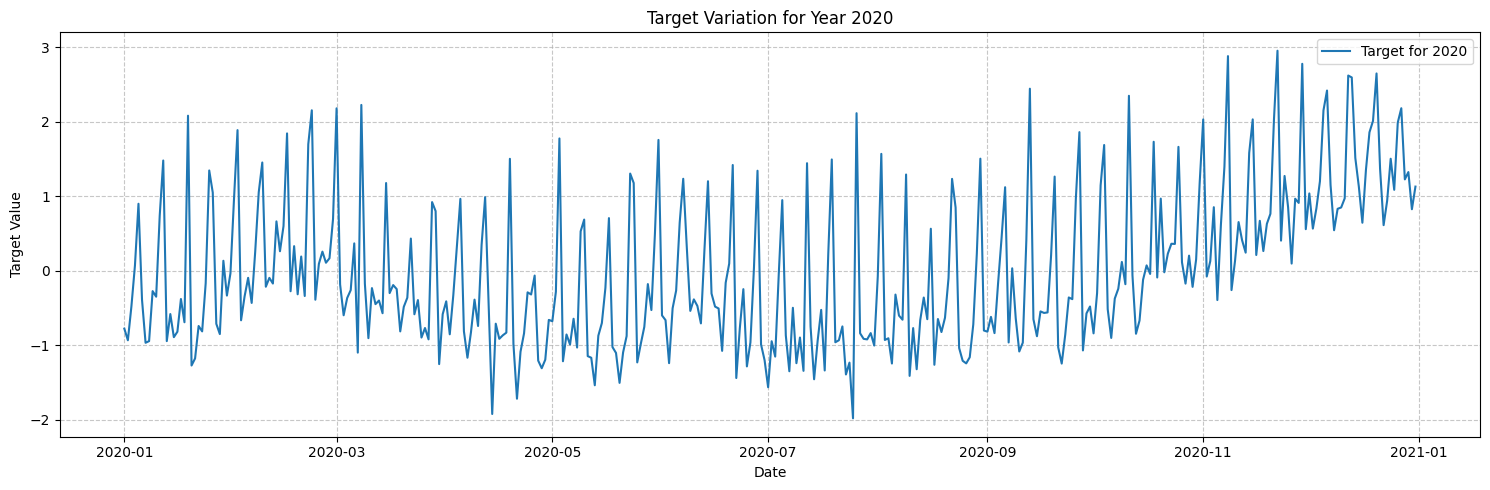

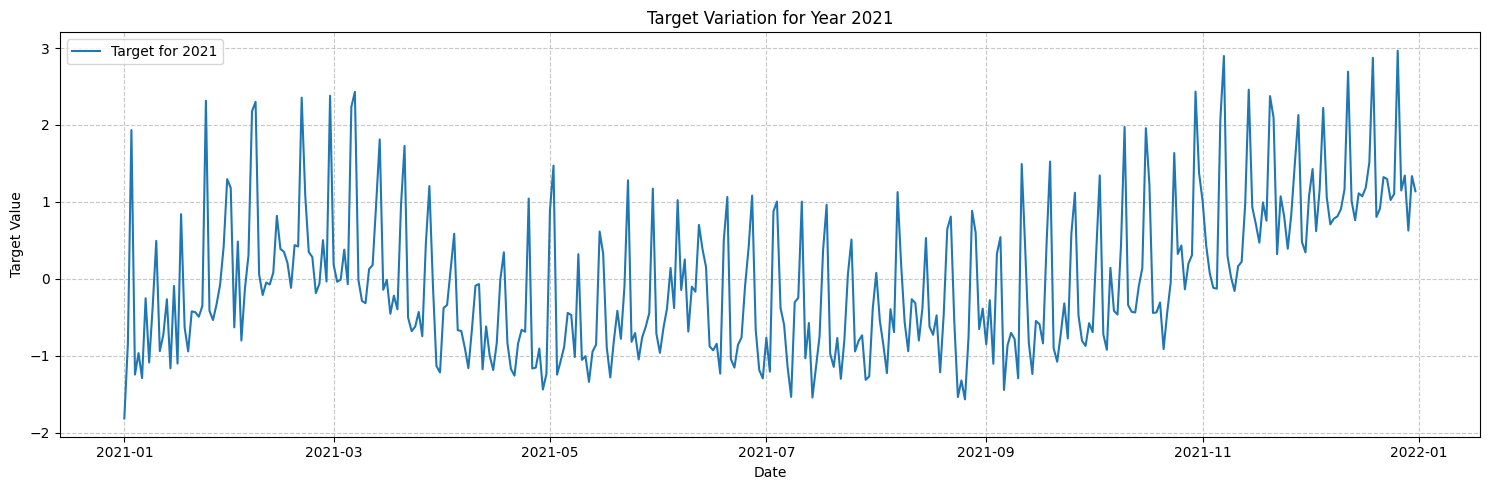

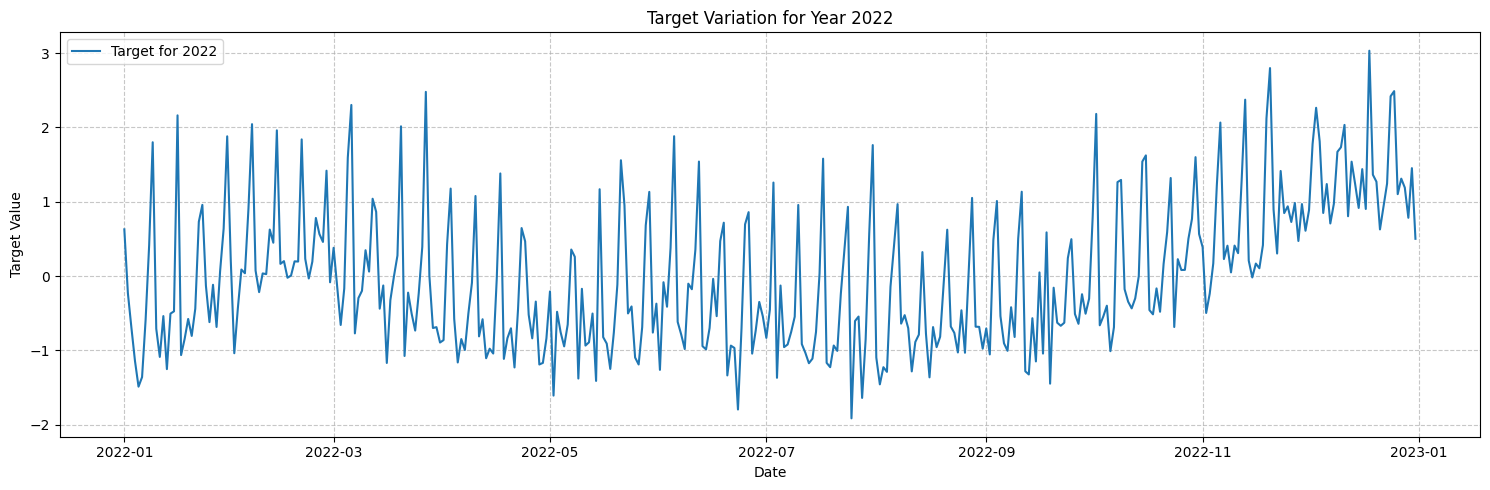

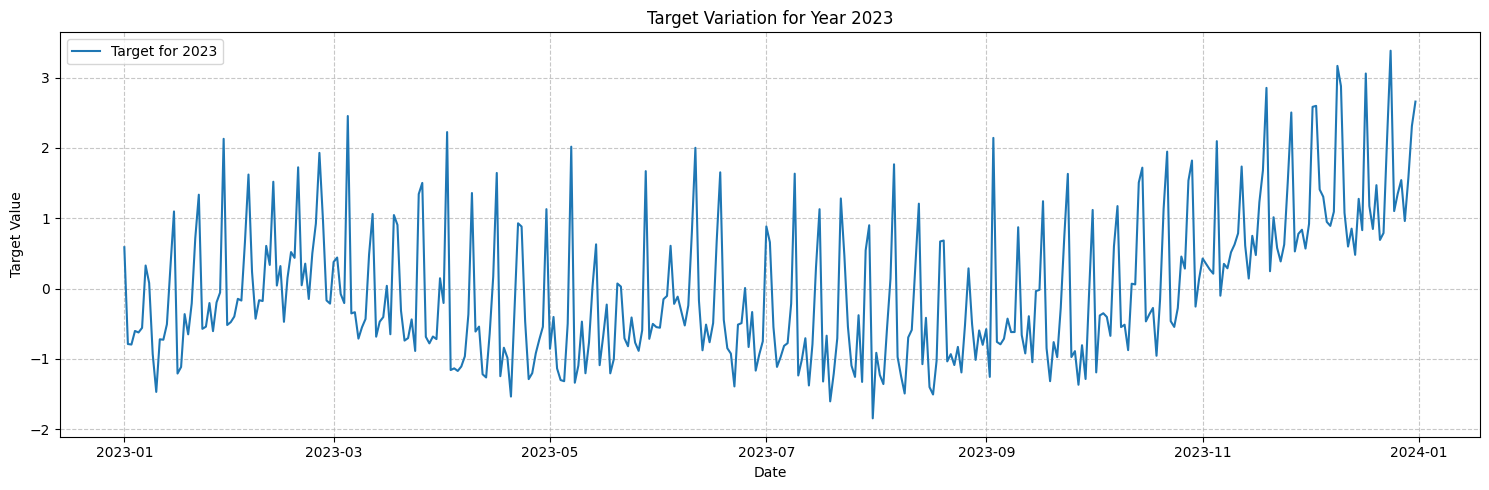

In [13]:
plot_yearly_data(df_scalled,'target_levelled_transf')

Now that we have our data levelled and standardized, we can start with the LSTM preparation.  
First we need to extract a support function. This function will guide the LSTM along a typical time series behaviour observed through the past data.  
Our support function will have the following format:  
  
$S_w(t) = w_d(t)^4 \cdot \sin(\omega_w \cdot w_d(t))$ - describes the weekly seasonalities.  
$S_{yi}(t) = e^{-\left(\frac{y_d(t) - c_i}{c_w}\right)^2}$ - describes the yearly seasonalities.



In [14]:
def get_suport_function(df,weekly_weight,yearly_weight):
	w = 1/7
	c1 = 50
	cw1 = 30
	c2 = 160
	cw2 = 10
	c3 = 365
	cw3 = 70

	df['weekday'] = df['date'].dt.dayofweek
	df['yearday'] = df['date'].dt.dayofyear
	df['week_season'] = df['weekday']**4*np.sin(w*df['weekday'])
	df['week_season'] = df['week_season']/df['week_season'].max()

	df['year_season_1'] = np.exp(-(df['yearday']-c1)**2/cw1**2)
	df['year_season_1'] = df['year_season_1']/df['year_season_1'].max()
	df['year_season_2'] = np.exp(-(df['yearday']-c2)**2/cw2**2)
	df['year_season_2'] = df['year_season_2']/df['year_season_2'].max()
	df['year_season_3'] = np.exp(-(df['yearday']-c3)**2/cw3**2)
	df['year_season_3'] = df['year_season_3']/df['year_season_3'].max()



	df['year_season'] = (2*df['year_season_1'] + df['year_season_2'] + 4*df['year_season_3'])/3

	df['year_season'] = (yearly_weight*df['year_season'] + weekly_weight*df['week_season'])/2
	df = df[['date','target','target_levelled_transf','year_season']]


	return df

df_scalled = get_suport_function(df_scalled,50,20)

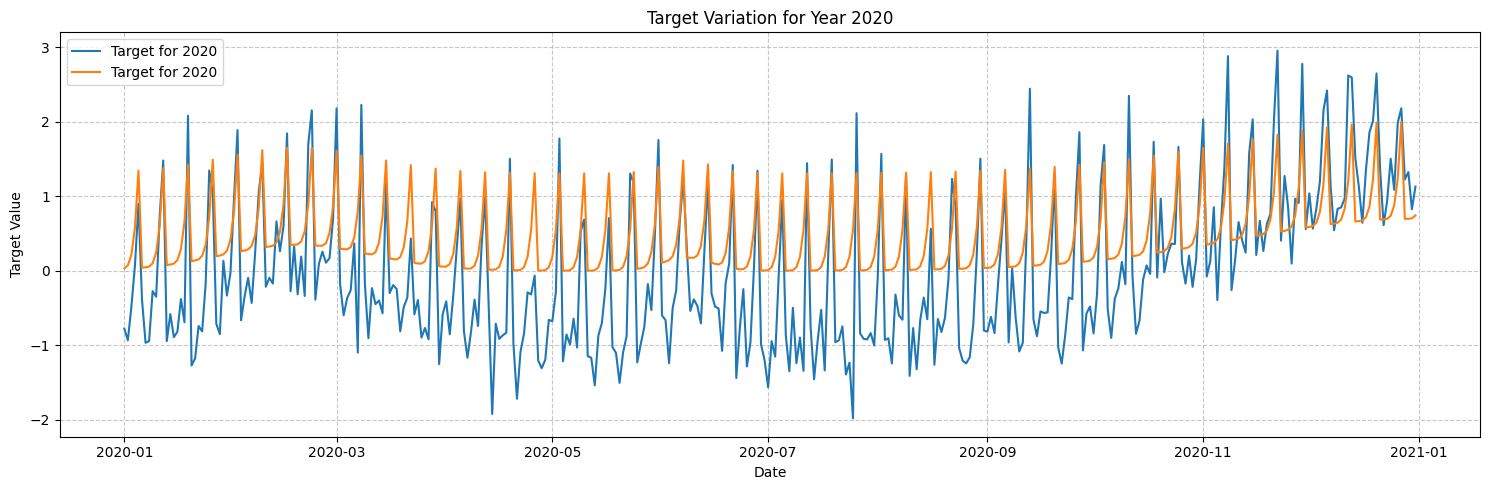

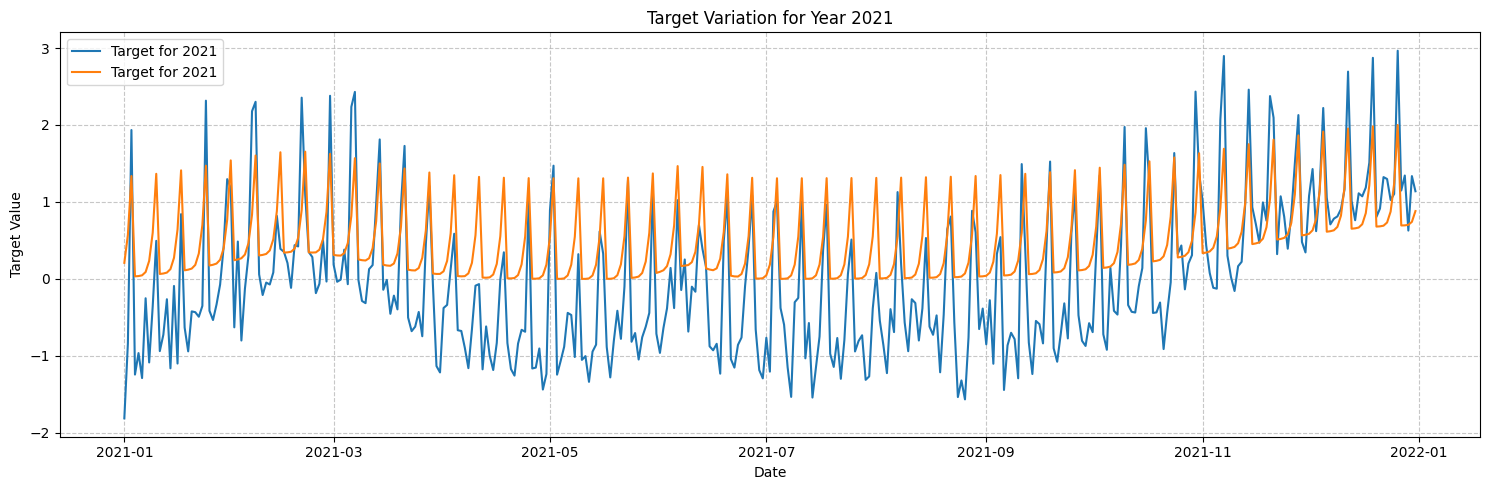

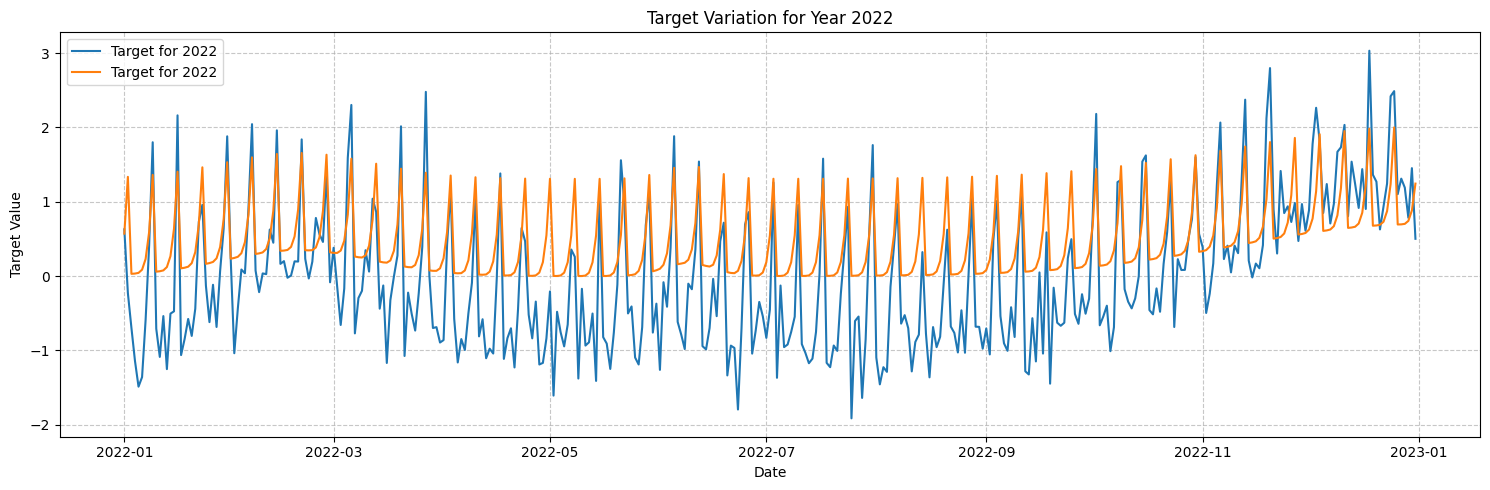

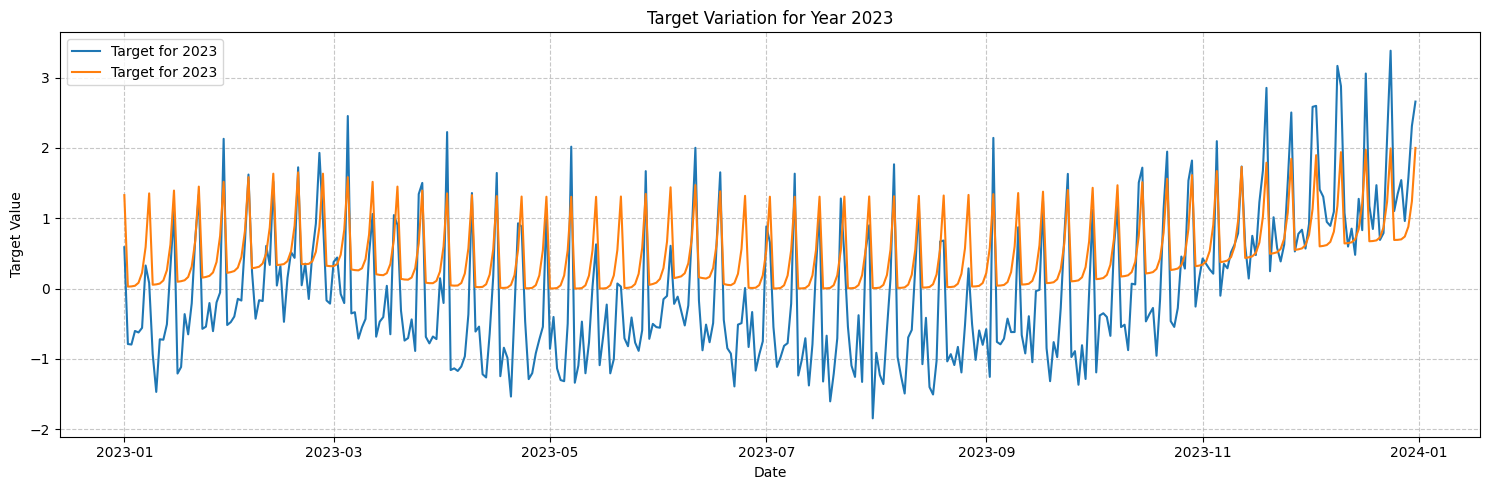

In [15]:
unique_years = df_scalled['date'].dt.year.unique().tolist()
    
for year in unique_years:
    plt.figure(figsize=(15, 5))

    year_data = df_scalled[df_scalled['date'].dt.year == year]

    plt.plot(year_data['date'], year_data['target_levelled_transf'], label=f'Target for {year}')
    plt.plot(year_data['date'], year_data['year_season']/year_data['year_season'].max()*2, label=f'Target for {year}')

    plt.title(f'Target Variation for Year {year}')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

We have our support function set up.  
Now we need to perform the standard procedure of spliting the data into train, validation period.

In [16]:
df_scalled

date      target  target_levelled_transf  year_season
0    2020-01-01  210.822618               -0.777471     0.577777
1    2020-01-02  207.980330               -0.933842     1.374296
2    2020-01-03  216.320550               -0.479759     4.105641
3    2020-01-04  226.761512                0.069131    11.082298
4    2020-01-05  243.301276                0.897752    25.702661
...         ...         ...                     ...          ...
1456 2023-12-27  307.799558                1.542607    13.404935
1457 2023-12-28  295.534048                0.960158    14.167797
1458 2023-12-29  308.384317                1.569793    16.855355
1459 2023-12-30  324.791300                2.312251    23.777823
1460 2023-12-31  332.755803                2.659246    38.333333

[1461 rows x 4 columns]

In [17]:
def create_periods(df,start_valid,end_valid):
	df['mode'] = np.nan
	df.loc[df['date']<=end_valid,'mode'] = 'valid'
	df.loc[df['date']<start_valid,'mode'] = 'train'
	df.loc[df['date']>end_valid,'mode'] = 'future'
	return df

In [18]:
start_valid = '2023-03-01'
end_valid = '2023-04-01'
df_scalled = create_periods(df_scalled,start_valid,end_valid)

In [19]:
df_scalled

date      target  target_levelled_transf  year_season    mode
0    2020-01-01  210.822618               -0.777471     0.577777   train
1    2020-01-02  207.980330               -0.933842     1.374296   train
2    2020-01-03  216.320550               -0.479759     4.105641   train
3    2020-01-04  226.761512                0.069131    11.082298   train
4    2020-01-05  243.301276                0.897752    25.702661   train
...         ...         ...                     ...          ...     ...
1456 2023-12-27  307.799558                1.542607    13.404935  future
1457 2023-12-28  295.534048                0.960158    14.167797  future
1458 2023-12-29  308.384317                1.569793    16.855355  future
1459 2023-12-30  324.791300                2.312251    23.777823  future
1460 2023-12-31  332.755803                2.659246    38.333333  future

[1461 rows x 5 columns]

In [20]:
# lookback and forecast lenght definition
n_lookback = 60
n_forecast = 31

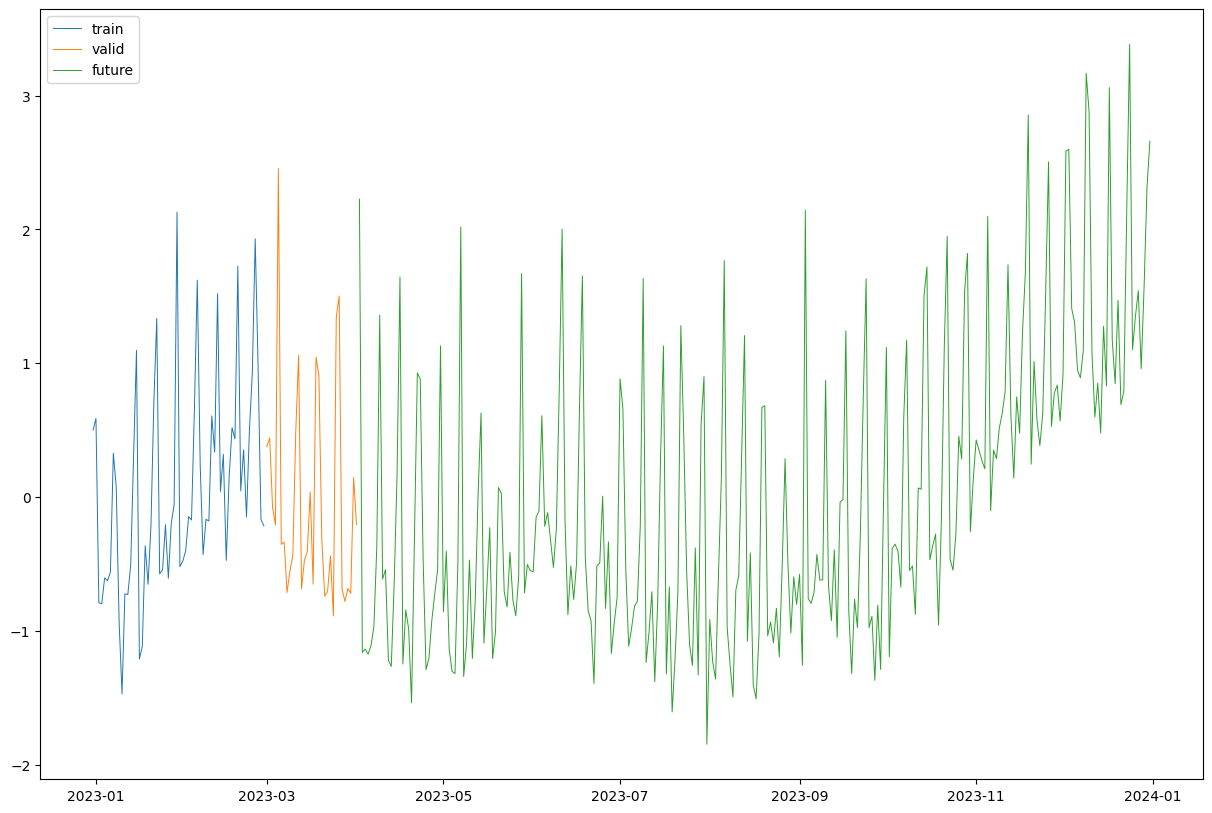

In [21]:
plt.figure(figsize=(15,10))
plt.plot(df_scalled[df_scalled['mode']=='train']['date'][-n_lookback:],
		 df_scalled[df_scalled['mode']=='train']['target_levelled_transf'][-n_lookback:],
		 label='train',
		 linewidth = 0.7)
plt.plot(df_scalled[df_scalled['mode']=='valid']['date'],
		 df_scalled[df_scalled['mode']=='valid']['target_levelled_transf'],
		 label='valid',
		 linewidth = 0.7)
plt.plot(df_scalled[df_scalled['mode']=='future']['date'],
		 df_scalled[df_scalled['mode']=='future']['target_levelled_transf'],
		 label='future',
		 linewidth = 0.7)
plt.legend()
plt.show()

The setting of the LSTM is of upmost importance.  
- We need to transform the data into arrays with the correct dimensions;  
- Create X and Y arrays - important to note that X will have 2 dimensions in this case (the n_lookback data points and the lagged n_forecast support function values);  

In [23]:
def prep_variables(df_input,grey_zone,variables):
    y_train = np.array(df_input.loc[df_input['mode'] == 'train'][variables])
    y_valid = np.array(df_input.loc[df_input['mode'] == 'valid'][variables])

    if grey_zone==True:
        y_train = y_train[:-n_lookback] 
    return (y_train,y_valid)

def createXY(dataset, n_lookback, n_forecast):
    dataX = []
    dataY = []
    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        past_values_col0 = dataset[i - n_lookback:i, 0]  # Select past n_lookback values from target
        future_values_col1 = dataset[i:i + n_forecast, 1]  # Select next n_forecast values from support

        if len(future_values_col1) < n_lookback:
            num_zeros_to_prepend = n_lookback - len(future_values_col1)
            future_values_col1 = np.concatenate((np.zeros(num_zeros_to_prepend), future_values_col1))

        combined_values = np.column_stack((past_values_col0, future_values_col1))

        dataX.append(combined_values)
        dataY.append(dataset[i:i + n_forecast, 0])

    return np.array(dataX), np.array(dataY)

def createX_valid(dataset, n_lookback, n_forecast):
    dataX = []
    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        past_values_col0 = dataset[i - n_lookback:i, 0]  # Select past n_lookback values from target
        future_values_col1 = dataset[i:i + n_forecast, 1]  # Select next n_forecast values from support

        if len(future_values_col1) < n_lookback:
            num_zeros_to_prepend = n_lookback - len(future_values_col1)
            future_values_col1 = np.concatenate((np.zeros(num_zeros_to_prepend), future_values_col1))

        combined_values = np.column_stack((past_values_col0, future_values_col1))

        dataX.append(combined_values)

    return np.array(dataX)

def prep_valid_data(y_train, y_valid):
    # gets last n_lookback values of train set
    y_train_last_period = y_train[-n_lookback:]
    # gets validation data
    modified_y_valid = y_valid[:n_forecast]
    # limits validation data to forecast period
    modified_valid = y_valid[:n_forecast].copy()
    # sets targets value to 0
    modified_valid[:, 0] = 0.0
    # stacks last period of train data on top of validation data forecast period
    valid_data = np.vstack((y_train_last_period,modified_valid))

    return (valid_data,modified_y_valid)

In [24]:
features = ['year_season']
grey_zone = False # must work on this
variables = ['target_levelled_transf'] + features

In [25]:
df_input = df_scalled[['date',
            'mode',
            #'weekday',
            ] + variables]

In [26]:
input_data =  prep_variables(df_input,grey_zone,variables)
y_train = input_data[0]
y_valid = input_data[1]
trainX, trainY = createXY(y_train, n_lookback, n_forecast)
valid_data = prep_valid_data(y_train, y_valid)
validX = valid_data[0]
modified_y_valid = valid_data[1]
validX = createX_valid(validX, n_lookback, n_forecast)

In [27]:
trainX[0]

array([[-0.77747141,  0.        ],
       [-0.93384233,  0.        ],
       [-0.47975865,  0.        ],
       [ 0.06913089,  0.        ],
       [ 0.89775192,  0.        ],
       [-0.39052768,  0.        ],
       [-0.96718732,  0.        ],
       [-0.94506063,  0.        ],
       [-0.27414572,  0.        ],
       [-0.34894439,  0.        ],
       [ 0.73611416,  0.        ],
       [ 1.47808132,  0.        ],
       [-0.94494056,  0.        ],
       [-0.58200396,  0.        ],
       [-0.89185919,  0.        ],
       [-0.81890547,  0.        ],
       [-0.38011203,  0.        ],
       [-0.69182715,  0.        ],
       [ 2.07902712,  0.        ],
       [-1.27225253,  0.        ],
       [-1.17729075,  0.        ],
       [-0.74214216,  0.        ],
       [-0.81447072,  0.        ],
       [-0.16753402,  0.        ],
       [ 1.34441345,  0.        ],
       [ 1.04752371,  0.        ],
       [-0.71243139,  0.        ],
       [-0.85065156,  0.        ],
       [ 0.132991  ,

As it can be observed, the first column refers to the time series past n_lookback period data points, whilst the second column contains the support function values of the forecast period.  
In a sense, we will use the past time series values and the future support function values to guide our LSTM.

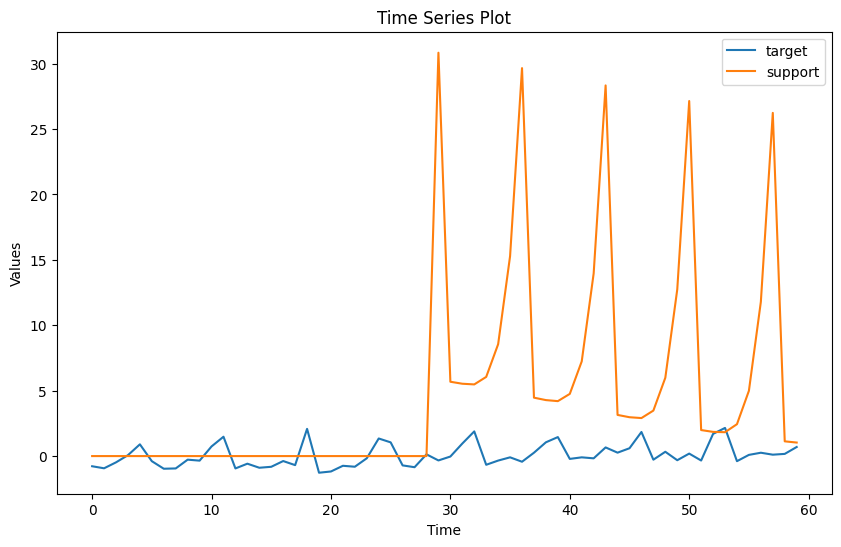

In [28]:
# Extract the columns
target_array = [row[0] for row in trainX[0]]
support_array = [row[1] for row in trainX[0]]

# Create time values (assuming each row represents a time point)
time_points = range(len(trainX[0]))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_points, target_array, label='target')
plt.plot(time_points, support_array, label='support')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Time Series Plot')
plt.show()

The image describes the input data setting.  
We will use the following LSTM architecture, but it depends on the case to which it will be applied and must be subject to proper grid search on order to obtain the best parameters.

In [29]:
def build_model(n_forecast,trainX):
    # Create the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True,
                    input_shape=(n_lookback, trainX.shape[2])))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(LSTM(72, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_forecast))  # Output layer now has n_forecast units

    # Configure the optimizer with the specified learning rate
    opt = Adam()

    model.compile(loss='mean_absolute_error', optimizer=opt)
    return model
def clear_weights(model):
    model.reset_states()

In [30]:


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

best_batch_size = 32
best_epochs = 100


early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
								patience=20,          # Number of epochs with no improvement after which training will be stopped
								restore_best_weights=True)
model = build_model(n_forecast,trainX)
clear_weights(model)
# Train the model with the learning rate scheduler
history = model.fit(trainX, trainY,
			batch_size=best_batch_size,
			epochs=best_epochs,
			validation_split=0.1,  # Use a portion of the training data as validation set
			callbacks=[early_stopping],
			verbose=1
			#, callbacks=[lr_scheduler]
			)

Epoch 1/100
30/30 [==============================] - 11s 186ms/step - loss: 0.7726 - val_loss: 0.7278
Epoch 2/100
30/30 [==============================] - 5s 165ms/step - loss: 0.6831 - val_loss: 0.6244
Epoch 3/100
30/30 [==============================] - 5s 160ms/step - loss: 0.6373 - val_loss: 0.5770
Epoch 4/100
30/30 [==============================] - 5s 161ms/step - loss: 0.6274 - val_loss: 0.5831
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6211 - val_loss: 0.5569
Epoch 6/100
30/30 [==============================] - 5s 161ms/step - loss: 0.6147 - val_loss: 0.5411
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6113 - val_loss: 0.5333
Epoch 8/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6086 - val_loss: 0.5389
Epoch 9/100
30/30 [==============================] - 5s 170ms/step - loss: 0.6074 - val_loss: 0.5513
Epoch 10/100
30/30 [==============================] - 5s 169ms/step - loss: 0.6060 - val_l

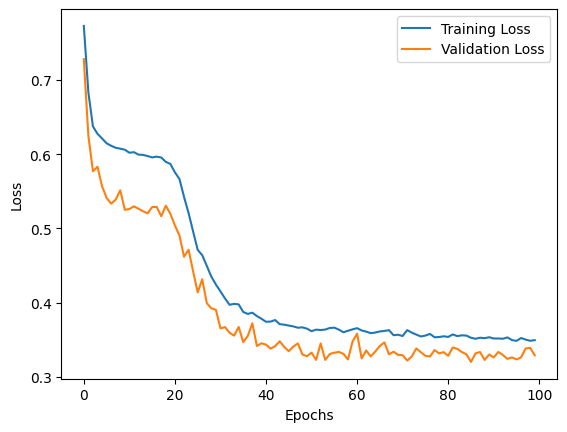

In [31]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
    

# Plot the training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:



pred_valid = model.predict(validX)

1/1 [==============================] - 1s 577ms/step


In [33]:
# function to post process data
def post_process_model_data(df,target,pred_valid,scaler,n_forecast):

    pred_valid_copies = pred_valid.reshape(-1,1)
    pred_valid_2=scaler.inverse_transform(pred_valid_copies)


    df_compare = df.copy()
    df_compare['pred']=np.nan
    df_compare = df_compare.loc[df_compare['mode']=='valid'].iloc[:n_forecast]
    df_compare['pred'] = pred_valid_2
    df_compare['pred'] = np.exp(df_compare['pred'])
    df_compare = df_compare[['date',target,'pred']]

    return df_compare

In [34]:
df_compare = post_process_model_data(df_scalled,'target',pred_valid,scaler,n_forecast)

In [35]:
df_scalled

date      target  target_levelled_transf  year_season    mode
0    2020-01-01  210.822618               -0.777471     0.577777   train
1    2020-01-02  207.980330               -0.933842     1.374296   train
2    2020-01-03  216.320550               -0.479759     4.105641   train
3    2020-01-04  226.761512                0.069131    11.082298   train
4    2020-01-05  243.301276                0.897752    25.702661   train
...         ...         ...                     ...          ...     ...
1456 2023-12-27  307.799558                1.542607    13.404935  future
1457 2023-12-28  295.534048                0.960158    14.167797  future
1458 2023-12-29  308.384317                1.569793    16.855355  future
1459 2023-12-30  324.791300                2.312251    23.777823  future
1460 2023-12-31  332.755803                2.659246    38.333333  future

[1461 rows x 5 columns]

In [36]:
df_compare = df_scalled.merge(df_compare[['date','pred']],on='date',how='left')

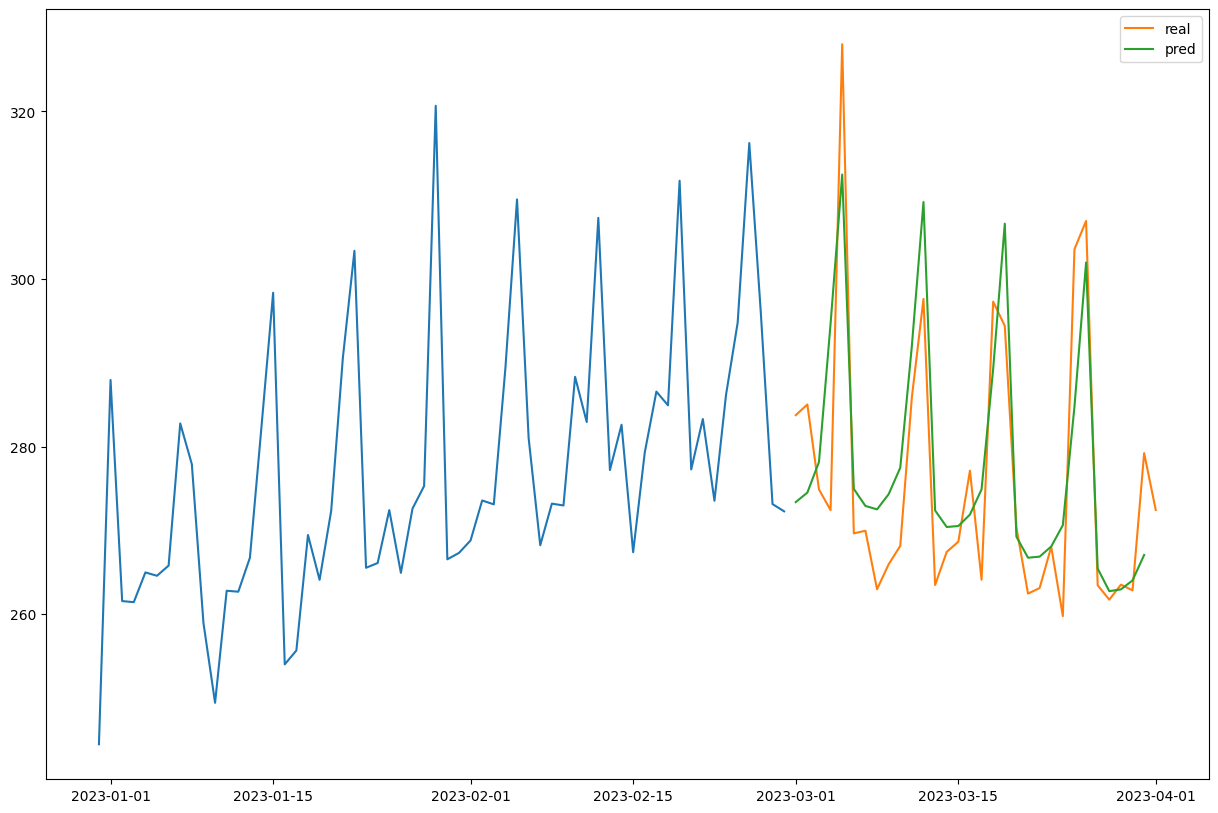

In [37]:
plt.figure(figsize=(15, 10))
plt.plot(df_compare['date'].loc[df_compare['mode']=='train'][-n_lookback:],
		 df_compare['target'].loc[df_compare['mode']=='train'][-n_lookback:])
plt.plot(df_compare['date'].loc[df_compare['mode']=='valid'],
		 df_compare['target'].loc[df_compare['mode']=='valid'],label='real')
plt.plot(df_compare['date'].loc[df_compare['mode']=='valid'],
		 df_compare['pred'].loc[df_compare['mode']=='valid'],label='pred')
plt.legend()

Now we have our predictions.  
In order to evaluate the model performance, we will use MAPE and perform a cross validation on the future timestamps.

In [38]:
df_compare['PE'] = df_compare['pred'] - df_compare['target']
df_compare['APE'] = df_compare['PE'].abs()

## Cross Val

1/1 [==============================] - 0s 38ms/step


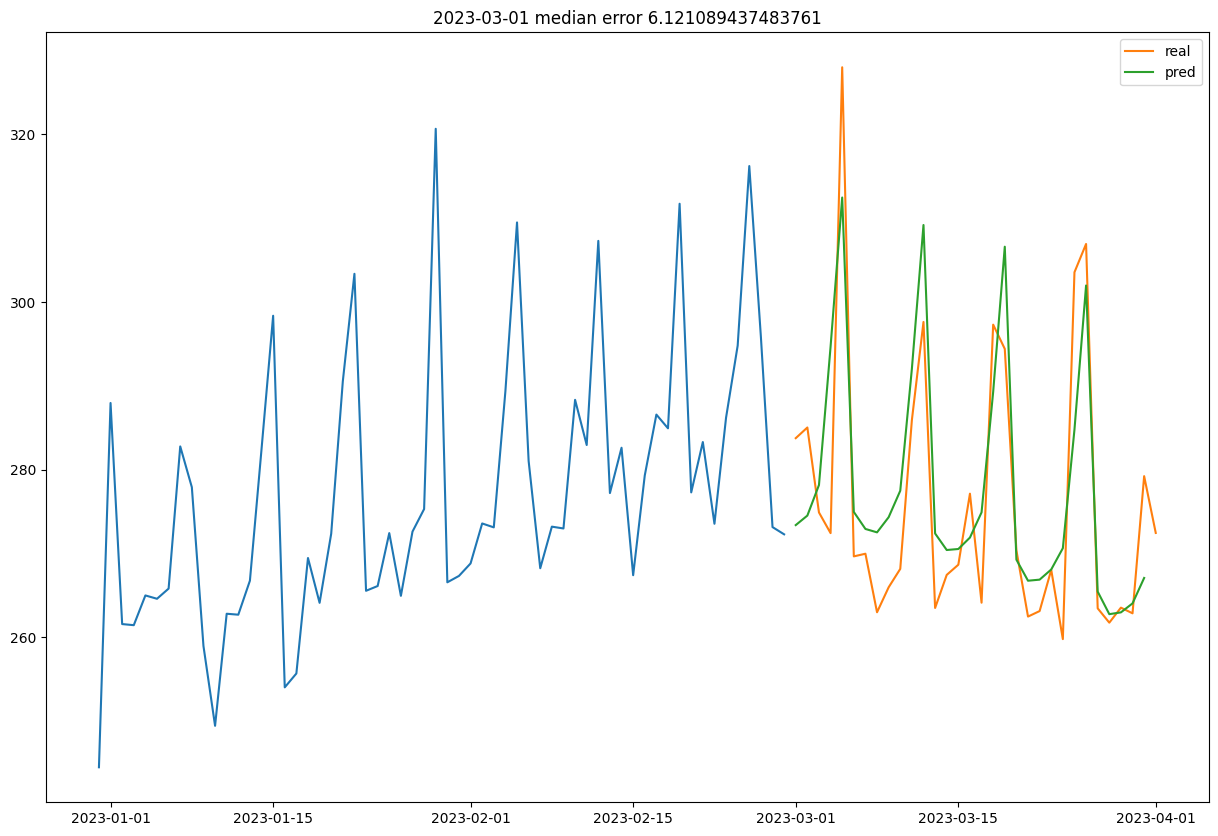

1/1 [==============================] - 0s 41ms/step


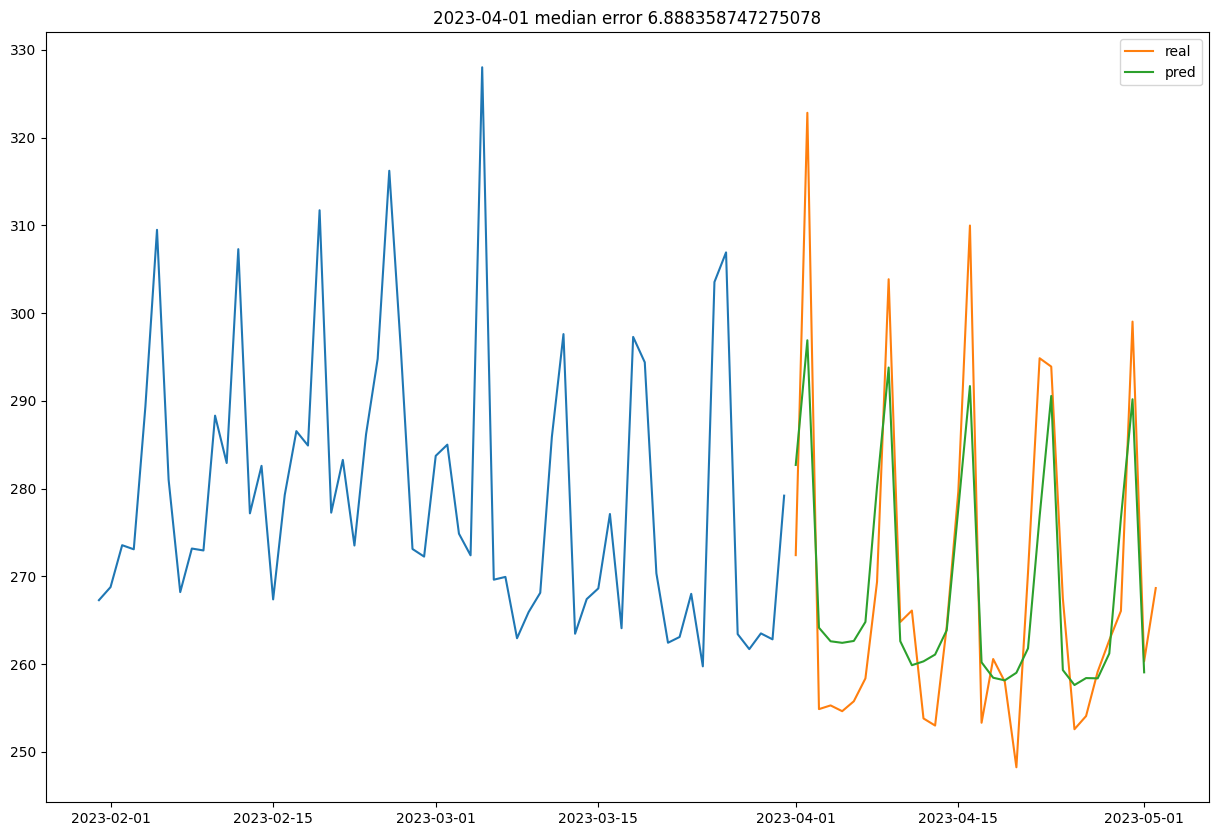

1/1 [==============================] - 0s 35ms/step


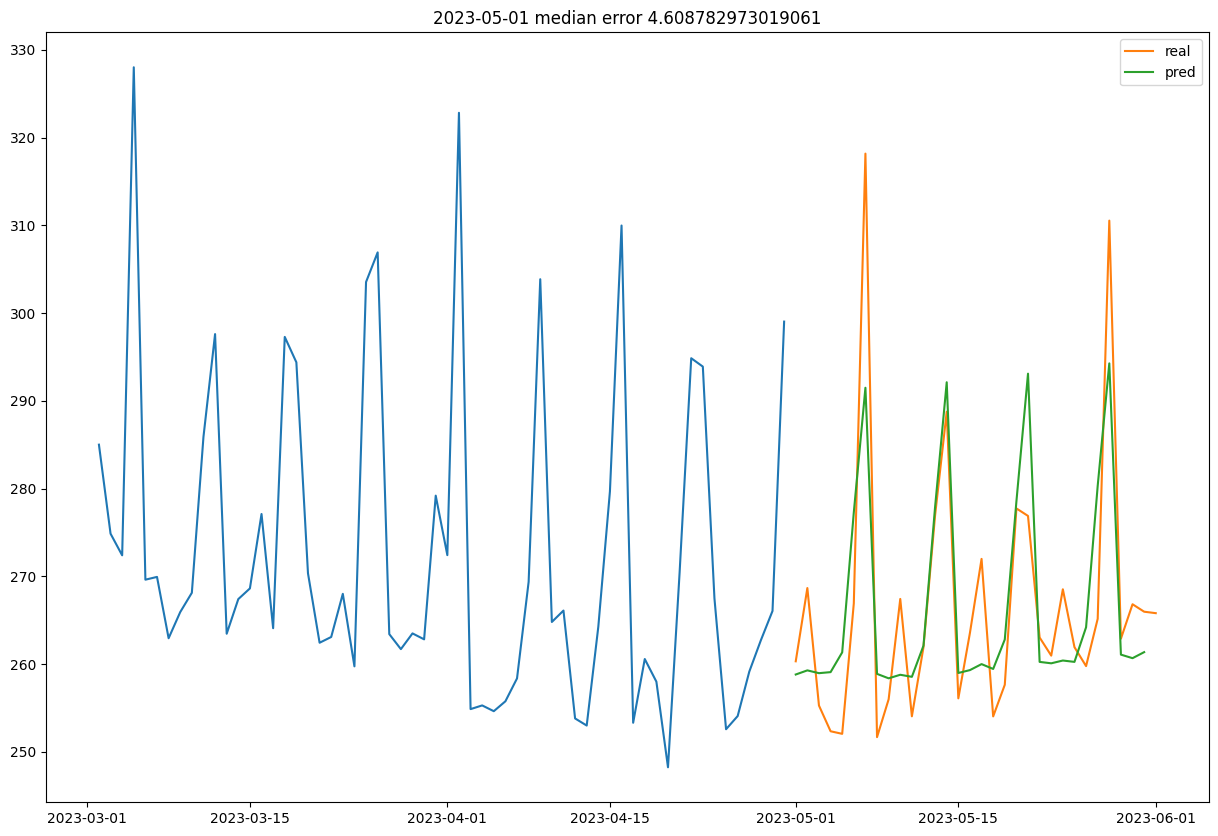

1/1 [==============================] - 0s 33ms/step


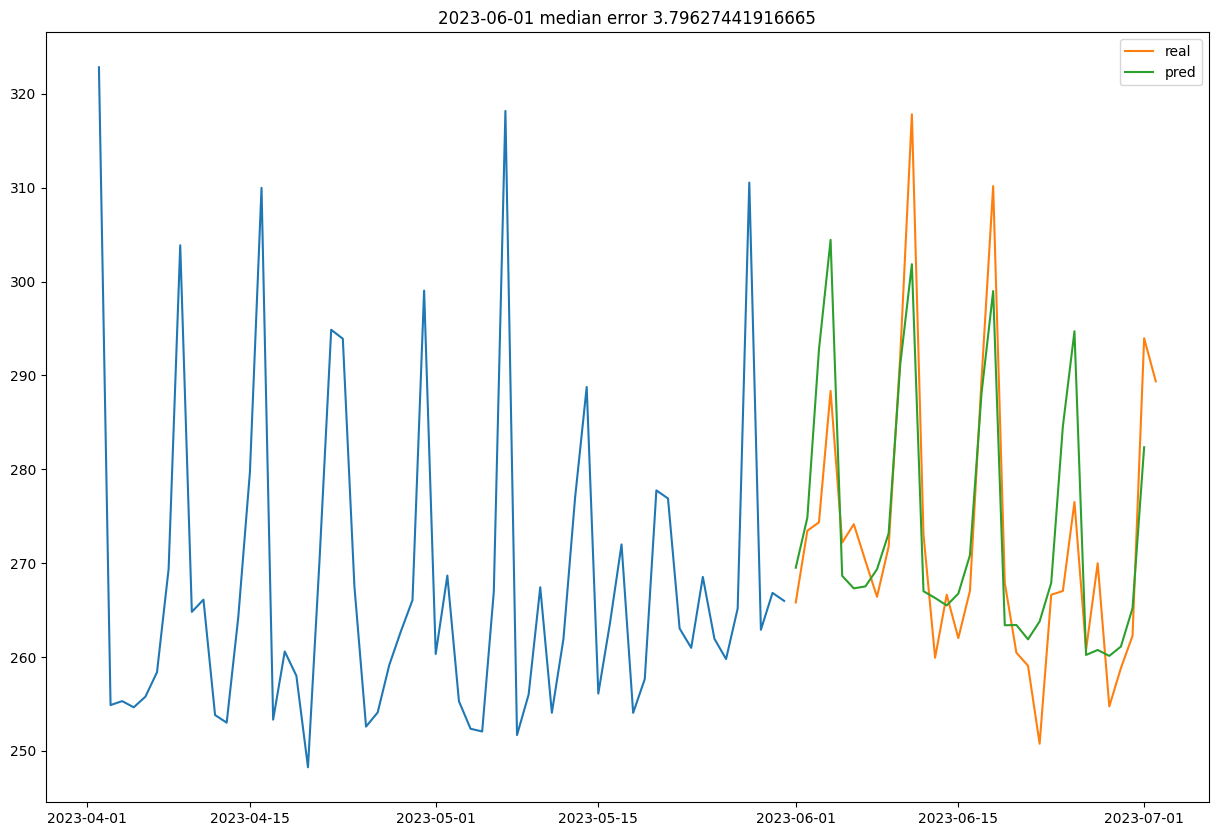

1/1 [==============================] - 0s 36ms/step


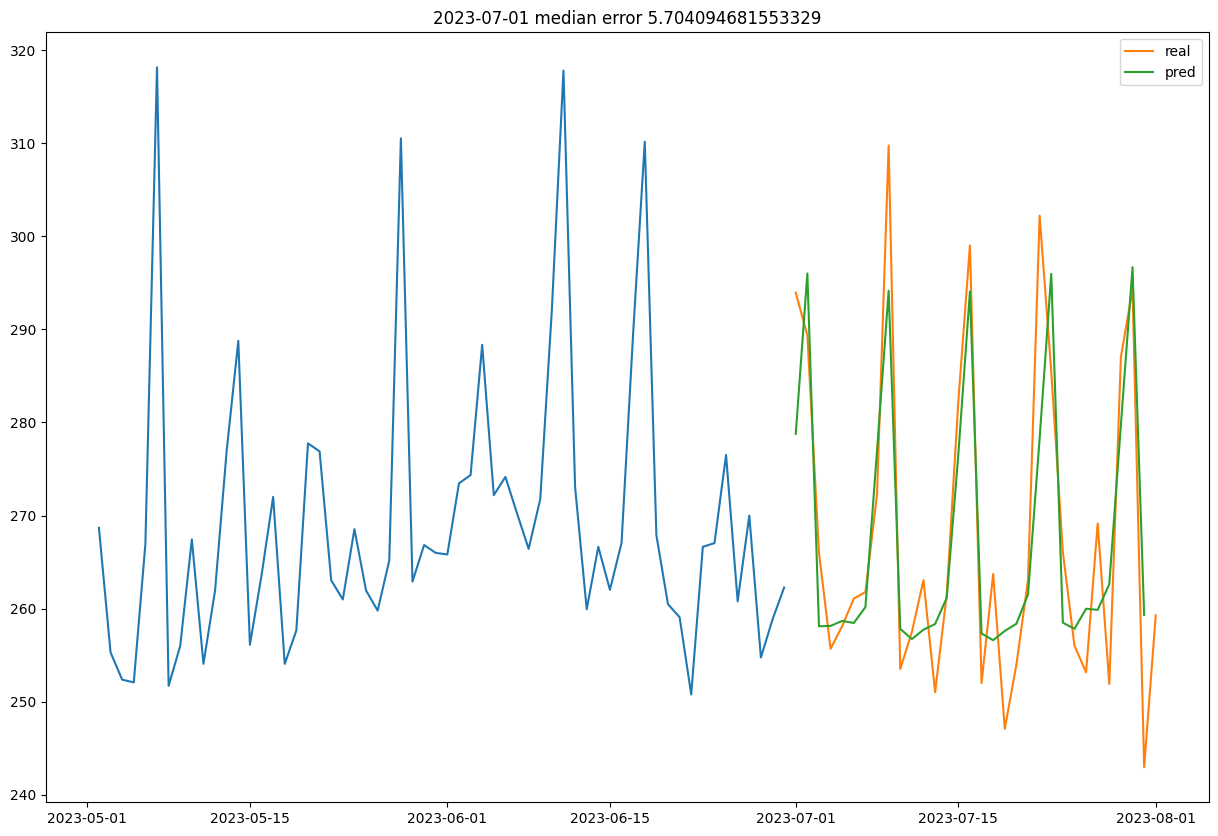

1/1 [==============================] - 0s 35ms/step


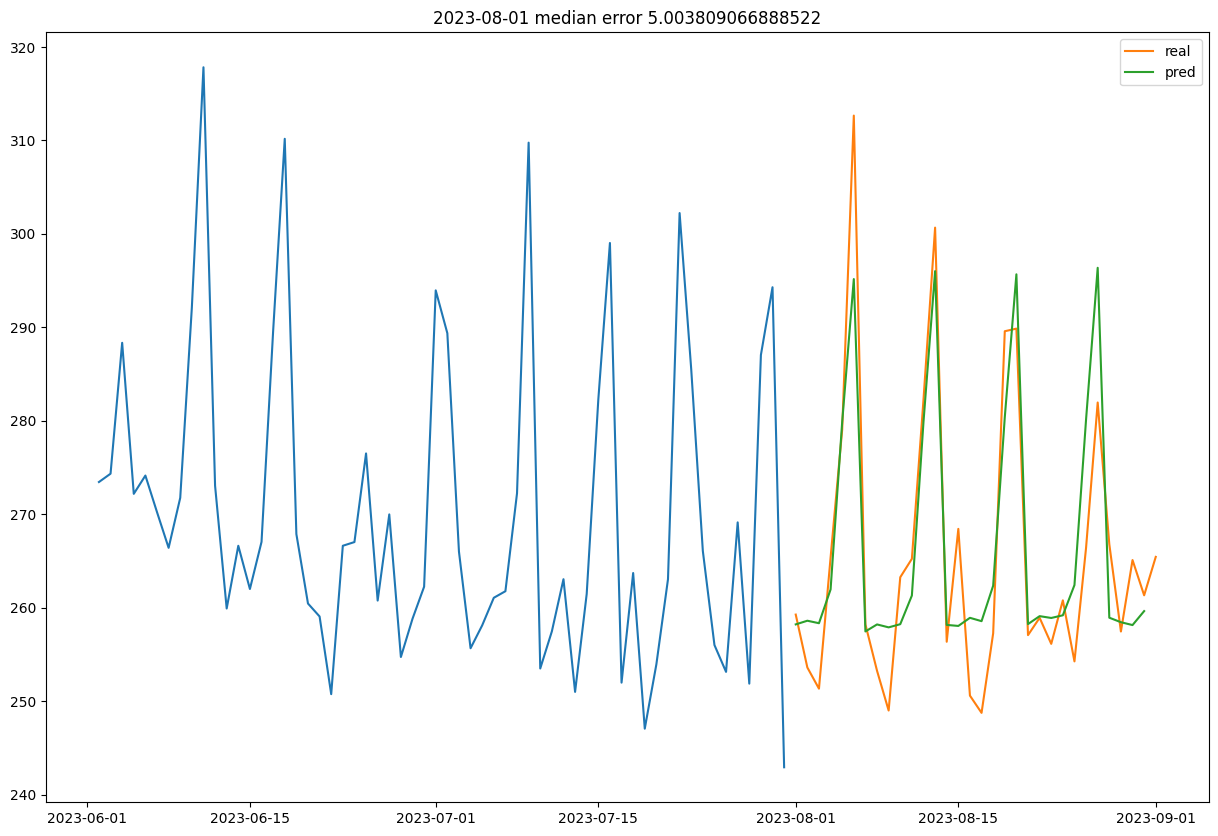

1/1 [==============================] - 0s 36ms/step


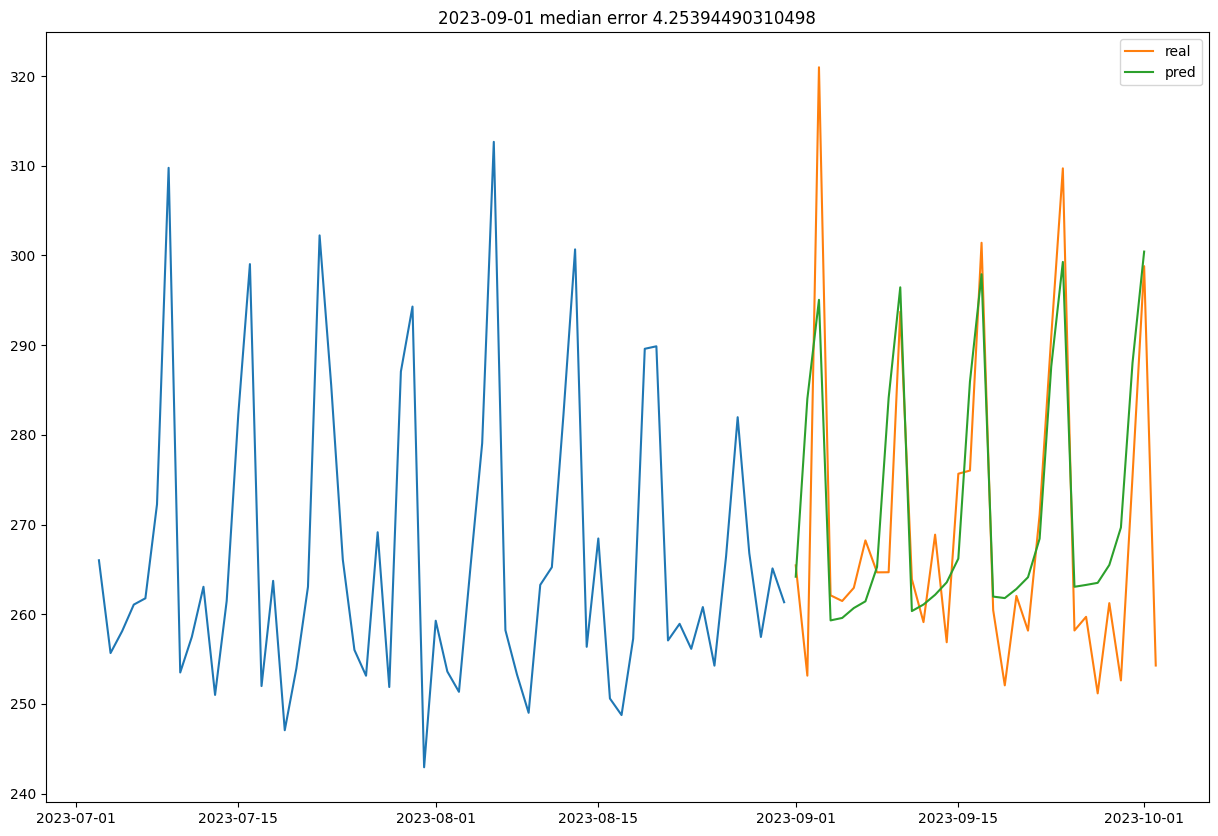

1/1 [==============================] - 0s 34ms/step


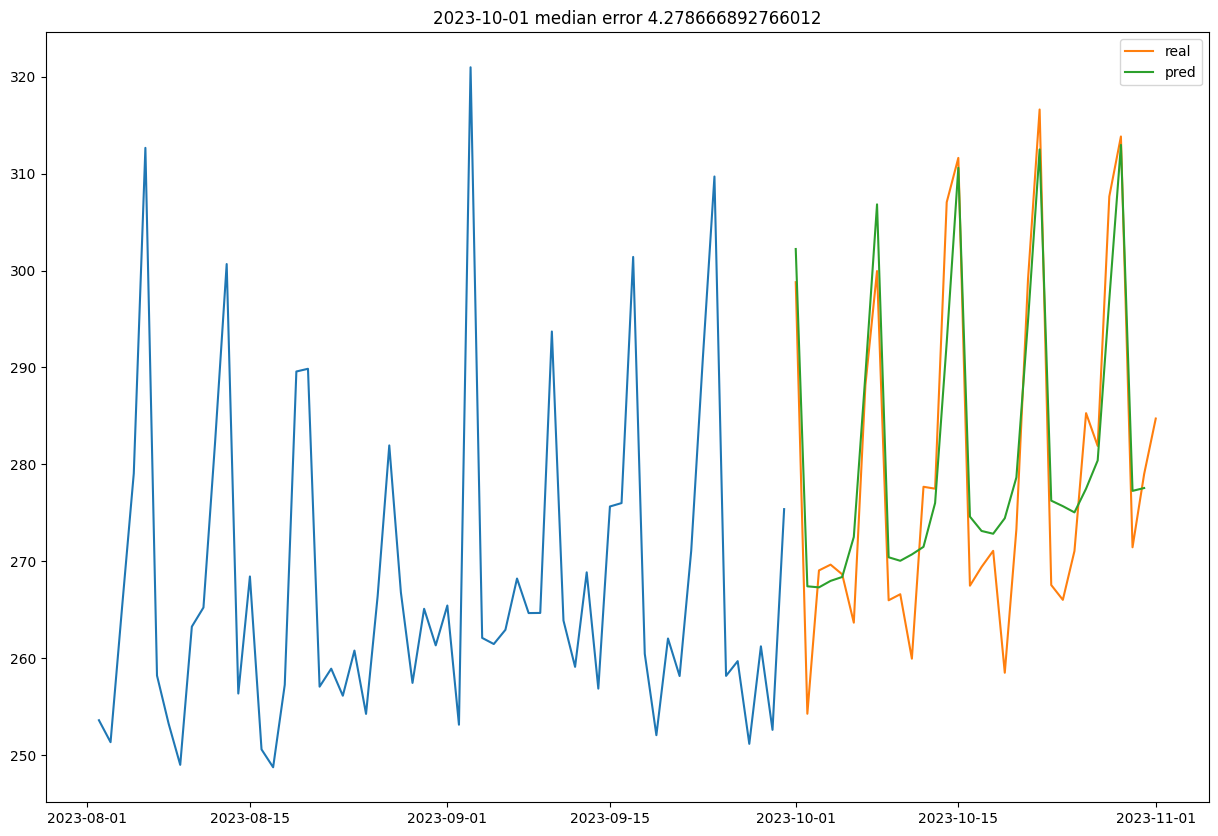

1/1 [==============================] - 0s 37ms/step


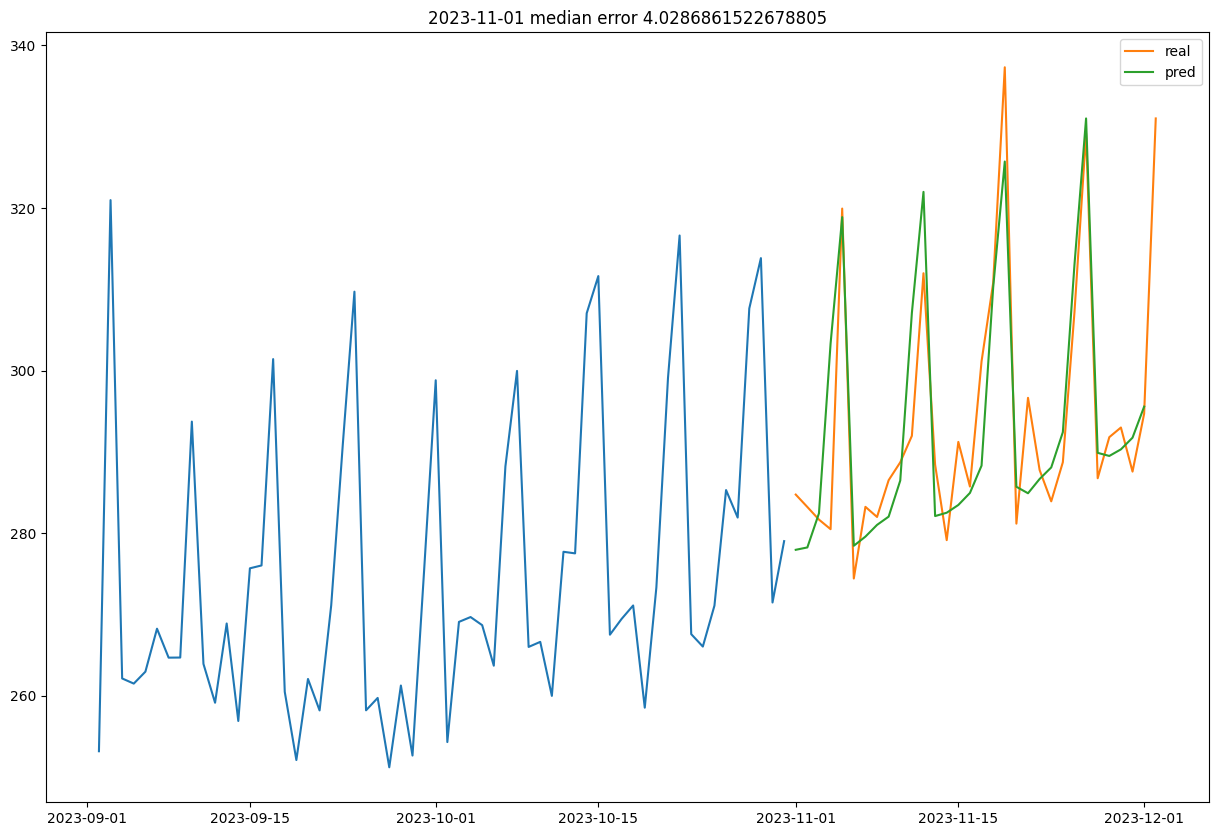

In [41]:
df_test = pd.DataFrame(columns=['date', 'MAPE'])
for month in ['03', '04', '05', '06', '07','08','09','10','11']:
    
    df_test_1 = pd.DataFrame(columns=['date', 'MAPE'])
    start_valid = '2023-{}-01'.format(month)
    end_valid = pd.to_datetime(start_valid) + pd.DateOffset(days=n_forecast)
    end_valid.strftime('%Y-%m-%d')
    df_test_1['date'] = start_valid
    df_scalled = create_periods(df_scalled,start_valid,end_valid)

    df_input = df_scalled[['date',
                'mode',
                #'weekday',
                ] + variables]

    input_data =  prep_variables(df_input,grey_zone,variables)
    y_train = input_data[0]
    y_valid = input_data[1]
    trainX, trainY = createXY(y_train, n_lookback, n_forecast)
    valid_data = prep_valid_data(y_train, y_valid)
    validX = valid_data[0]
    modified_y_valid = valid_data[1]
    validX = createX_valid(validX, n_lookback, n_forecast)

    pred_valid = model.predict(validX)

    df_compare = post_process_model_data(df_scalled,'target',pred_valid,scaler,n_forecast)
    df_compare = df_scalled.merge(df_compare[['date','pred']],on='date',how='left')
    df_compare['PE'] = df_compare['pred'] - df_compare['target']
    df_compare['APE'] = df_compare['PE'].abs()
    df_test_1['MAPE'] = df_compare['APE'].median()

    df_test = pd.concat([df_test, df_test_1], ignore_index=True)
    plt.figure(figsize=(15, 10))
    plt.title(start_valid +' median error ' + str(df_compare['APE'].median()))
    plt.plot(df_compare['date'].loc[df_compare['mode']=='train'][-n_lookback:],
            df_compare['target'].loc[df_compare['mode']=='train'][-n_lookback:])
    plt.plot(df_compare['date'].loc[df_compare['mode']=='valid'],
            df_compare['target'].loc[df_compare['mode']=='valid'],label='real')
    plt.plot(df_compare['date'].loc[df_compare['mode']=='valid'],
            df_compare['pred'].loc[df_compare['mode']=='valid'],label='pred')
    plt.legend()
    plt.show()

In [42]:
df_test = pd.DataFrame(columns=['date', 'MAPE'])
mape_values = []

for month in ['03', '04', '05', '06', '07','08','09','10','11']:
    df_test_1 = pd.DataFrame(columns=['date', 'MAPE'])
    start_valid = '2023-{}-01'.format(month)
    end_valid = pd.to_datetime(start_valid) + pd.DateOffset(days=n_forecast)
    end_valid.strftime('%Y-%m-%d')
    df_test_1['date'] = start_valid
    df_scalled = create_periods(df_scalled, start_valid, end_valid)

    df_input = df_scalled[['date',
                            'mode',
                            # 'weekday',
                            ] + variables]

    # Prepare Valid set
    input_data = prep_variables(df_input, grey_zone, variables)
    y_train = input_data[0]
    y_valid = input_data[1]
    trainX, trainY = createXY(y_train, n_lookback, n_forecast)
    valid_data = prep_valid_data(y_train, y_valid)
    validX = valid_data[0]
    modified_y_valid = valid_data[1]
    validX = createX_valid(validX, n_lookback, n_forecast)
    
    pred_valid = model.predict(validX)
    df_compare = post_process_model_data(df_scalled, 'target', pred_valid, scaler, n_forecast)
    df_compare = df_scalled.merge(df_compare[['date', 'pred']], on='date', how='left')
    df_compare['PE'] = df_compare['pred'] - df_compare['target']
    df_compare['APE'] = df_compare['PE'].abs()
    df_test_1['MAPE'] = df_compare['APE'].median()

    # Append start date and MAPE value to the lists
    mape_values.append({'start_date': start_valid, 'MAPE': df_compare['APE'].median()})


# Create a DataFrame from the list of dictionaries
df_mape = pd.DataFrame(mape_values)


1/1 [==============================] - 0s 38ms/step


In [43]:
df_mape

start_date      MAPE
0  2023-03-01  6.121089
1  2023-04-01  6.888359
2  2023-05-01  4.608783
3  2023-06-01  3.796274
4  2023-07-01  5.704095
5  2023-08-01  5.003809
6  2023-09-01  4.253945
7  2023-10-01  4.278667
8  2023-11-01  4.028686

## 4. Conclusion
We have now our results.  
It is clear that this method can provide accurate forecasts with considerable room for improvement.  
## 5. Further development Opportunities
This improvement can be reached with the following:  
- Application of and optimization algorithm to extract the best fitting support function parameters;  
- Inclusion of relevant data as extra features;  
- Use alternative and more suitable levelling methods.